# jnn 诞生
我把之前写的神经网络的代码做了一些整理。封装成一个叫 jnn 的库。  

> 激活函数放到 jnn.activFun  
代价函数放到 jnn.costFun  
神经网络网络 jnn.nn  
测试数据生成 jnn.dataFactory  
绘图常用工具 jnn.plot  
超级字典工具 jnn.ea  




In [1]:
import sys;
sys.path.append("../")
from jnn.plot import *
from jnn.nn import *
from jnn.activFun import eaActivFun
from jnn.costFun import eaCostFun
from jnn.dataFactory import *
from jnn.ea import Ea

## 1. 加载三分类测试数据

In [2]:
eaData = eaData3Classify()
# Ea 做了升级，支持格式化输出
Ea.show(eaData) 


 □[eaData]
 ├─ ☞[Type]: np.ndarray:(1, 3000)
 ├─ ☞[X]: np.ndarray:(2, 3000)
 └─ ☞[Y]: np.ndarray:(3, 3000)



## 2. 构造一个训练三分类器的神经网络结构

搞了很久才弄明白什么softmax到底是怎么回事。  
学习时，我们通常是从前人研究的结论进入，并不清楚前人研究出这个结论的前因和整个过程。这让我们在理解上没有方向，很是迷茫。往往要花很久时间。明白之后，通常会恍然大悟。

这里我只想提几个问题，沿着这些问题去理解softmax会更容易。
1. 神经网络的输出层是否可以是多维向量？
2. 以3分类器为例，在逻辑上实际上输出的是应该是什么？
3. 多分类预测问题，归一化预测概率，在不同分类上得到一个概率密度分布。
4. 交叉熵代价函数，名字太高大上，实际不就是我们熟悉的那个 -1/m * sum(ylog(yhat) + (1-y)log(1-yhat)), 当初在单分类问题上和sigmoid函数配合的很好的那个。在反向传递中，计算需要传递的导数，结果就是y与yhat的四则运算。
5. 多分类问题，设计和一个什么激活函数，能使其配合交叉熵代价函数计算反向传递导数时，还保持为y与yhat的四则运算呢？

不管是计算推导，还是碰巧发现，softmax满足了上边的需求。帮我们解决了多分类神经网络问题。

### 因此我们设计下边这个多分类神经网络。注意，输出层是3个单元。

In [3]:
net = Ea()
net.L = 2
net.n[0] = eaData.X.shape[0]  # nx
net.n[1] = 10
net.n[2] = 3
net.n[net.L] = 3
net.activFun[1] = eaActivFun.relu
net.activFun[2] = eaActivFun.softmax
net.costFun = eaCostFun.L4

Ea.show(net)


 □[net]
 ├─ ☞[L]: 2 
 ├─□[activFun]
 │ ├─□[1]
 │ │ ├─ ☞[dg]: dRelu() 
 │ │ ├─ ☞[g]: relu() 
 │ │ └─ ☞[name]: 'relu' 
 │ └─□[2]
 │   ├─ ☞[dg]: dSoftmax() 
 │   ├─ ☞[g]: softmax() 
 │   └─ ☞[name]: 'softmax' 
 ├─□[costFun]
 │ ├─ ☞[J]: crossSoftmax() 
 │ ├─ ☞[dJ]: dCrossSoftmax() 
 │ └─ ☞[name]: 'cross' 
 └─□[n]
   ├─ ☞[0]: 2 
   ├─ ☞[1]: 10 
   └─ ☞[2]: 3 



### 初始化参数训练神经网络

In [4]:
net = nnInitWb(net)
net = nnFit(eaData, net, learn_rate=0.1)
Ea.show(net, 3)


 □[net, 3]
 ├─ ☞[L]: 2 
 ├─□[W]
 │ ├─ ☞[1]: np.ndarray:(10, 2)
 │ └─ ☞[2]: np.ndarray:(3, 10)
 ├─□[activFun]
 │ ├─□[1]
 │ │ ├─ ☞[dg]: dRelu() 
 │ │ ├─ ☞[g]: relu() 
 │ │ └─ ☞[name]: 'relu' 
 │ └─□[2]
 │   ├─ ☞[dg]: dSoftmax() 
 │   ├─ ☞[g]: softmax() 
 │   └─ ☞[name]: 'softmax' 
 ├─□[b]
 │ ├─ ☞[1]: np.ndarray:(10, 1)
 │ └─ ☞[2]: np.ndarray:(3, 1)
 ├─□[costFun]
 │ ├─ ☞[J]: crossSoftmax() 
 │ ├─ ☞[dJ]: dCrossSoftmax() 
 │ └─ ☞[name]: 'cross' 
 ├─□[costs]: list(757)
 │ ├─ ☞[0]: 2.01 
 │ ├─ ☞[1]: 1.71 
 │ ├─ ☞[2]: 1.53 
 │ └─ ☞[.]: ... 
 ├─ ☞[learn_rate]: 0.10 
 └─□[n]
   ├─ ☞[0]: 2 
   ├─ ☞[1]: 10 
   └─ ☞[2]: 3 



### 把分类漂亮的画出来

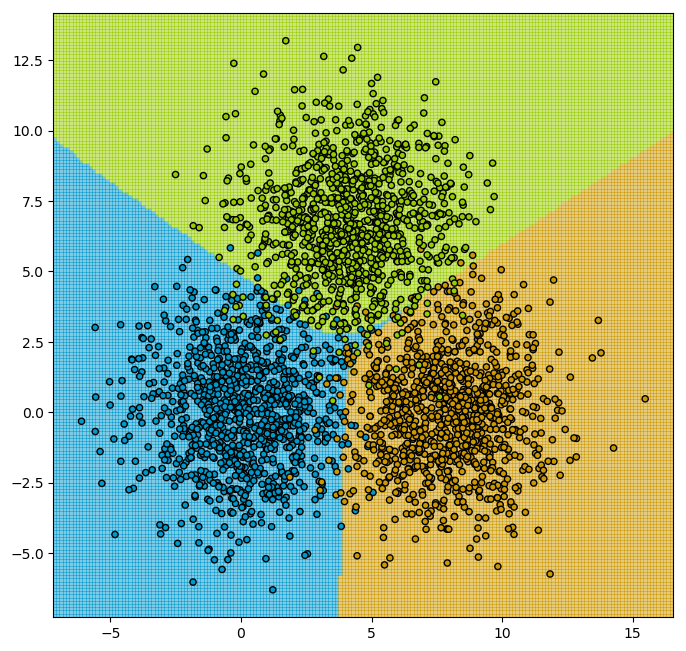

In [5]:
plotPredict(net, eaData.X, eaData.Type, cmap=['#0099CC', '#CC9900','#99CC00'])

### 最后看看我们的损失函数下降情况

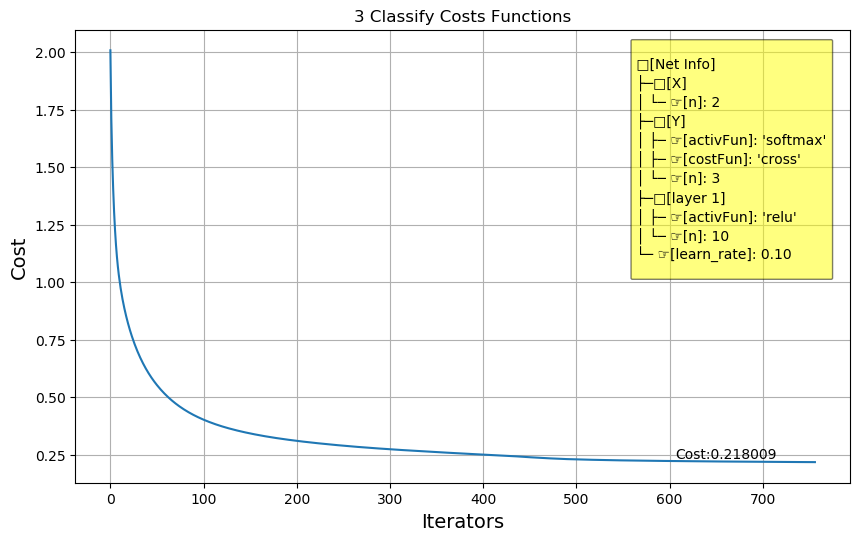

In [6]:
plotCost("3 Classify Costs Functions", net.costs,netInfo=eaNetInfo(net))